### Simple Example for Fitting a Hidden Markov Model (HMM) 

This notebook is designed to help users get started using the glm-hmm package to fit HMMs to their data. Here we use simulated data so that we can check that we are inferring the correct model parameters, but the same fitting procedure applies when using real experimental data. All the same general ideas (code structure and parameter validation) also apply when fitting GLM-HMMs. For more details on that model, see the fit-glm-hmm.ipynb notebook. 

#### 1. Import the required code packages and modules.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from glmhmm import hmm
from glmhmm.utils import permute_states, find_best_fit
from glmhmm.visualize import plot_model_params

#### 2. Set the hyper-parameters of the HMM

In [2]:
N = 20000 # number of data/time points
K = 2 # number of latent states
C = 2 # number of observation classes

#### 3. Instantiate the model and generate true parameters

The parameters of an HMM include the transition probabilities $A$, the observation (or emission) probabilities $\phi$, and the initial state probabilities $\pi$.

In [3]:
true_HMM = hmm.HMM(N,0,C,K)
A_true,phi_true,pi_true = true_HMM.generate_params()

#### 4. Given the true parameters, generate some data. 

The data include the observations $y$ and the latent states $z$ at each time point. 

In [4]:
true_y,true_z = true_HMM.generate_data(A_true,phi_true)

#### 5. Fit the model

The fitting code uses the expectation maximization (EM) algorithm to infer the model parameters. Because EM does not guarantee that it will find the best fit (global optimum) and inference is often dependent on the choice of parameter initialization, it is often best to fit the model multiple times using different initializations and then select the best one based on which fit obtained the highest log-likelihood. <b>Note:</b> For this example, we are not inferring the initial state probabilities, but instead assuming a uniform distribution over the initial states. See the deterministic annealing HMM notebook for an example where we also infer the initial state probabilities.

In [15]:
inits = 2 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
phi_all = np.zeros((inits,K,C))

# fit the model for each initialization
for i in range(inits):
    A_init,phi_init,pi_init = true_HMM.generate_params() # initialize the model parameters
    lls_all[i,:],A_all[i,:,:],phi_all[i,:,:],pi0 = true_HMM.fit(true_y,A_init,phi_init) # fit the model
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete


#### 6. Compare the inferred model parameters for the best fit to the true parameter values.

Text(0.5, 1.0, 'Inferred $\\phi$')

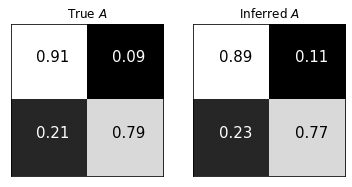

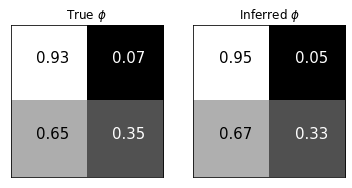

In [39]:
bestix = find_best_fit(lls_all) # find the initialization that led to the best fit

# for easy comparison permute the states in order from highest to lowest self-transition probability
A_permuted, order = permute_states(A_all[bestix])
A_true_permuted, order_true = permute_states(A_true)

# plot the true vs. inferred transition probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(A_true_permuted,ax[0])
plot_model_params(A_permuted, ax[1])

ax[0].set_title('True $A$')
ax[1].set_title('Inferred $A$')

# permute the observation probability matrices according to the above order
phi_permuted,_ = permute_states(phi_all[bestix],method='order',param='observations',order=order)
phi_true_permuted,_ = permute_states(phi_true,method='order',param='observations',order=order_true)

# plot the true vs. inferred observation probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(phi_true_permuted,ax[0])
plot_model_params(phi_permuted, ax[1])

ax[0].set_title('True $\phi$')
ax[1].set_title('Inferred $\phi$')

#### 7. Cross validation can further assess model performance.

We can also compare the true vs inferred log-likelihood to see how close we came to the global optimum in our fitting procedure. The best way to do this is to use cross validation, where we split the data into training and test sets and compare the log-likelihoods of the test data. To be rigorous, we should use <i>multi-fold</i> cross-validation, where we split the data into multiple (non-overlapping) train and test sets, fit the model to each of the train sets, evaluate the log-likelihood on each of the test sets, and then take the average. 

In [40]:
# split the data into five folds
folds = 5
train_size = int(N - N/folds)
test_size = int(N/folds)
y_train = np.zeros((folds,train_size))
y_test = np.zeros((folds,test_size))
kf = KFold(n_splits=folds)
kf.get_n_splits(true_y)
for i, (train_index, test_index) in enumerate(kf.split(true_y)):
    y_train[i,:], y_test[i,:] = true_y[train_index], true_y[test_index]

In [41]:
inits = 2 # set the number of initializations
true_HMM.n = train_size # reset the number of data points in accordance with the size of the training set
# store values for each initialization
A_all = np.zeros((folds,inits,K,K))
phi_all = np.zeros((folds,inits,K,C))

# fit the model for each training set and each initialization
for i in range(folds):
    for j in range(inits):
        A_init,phi_init,pi_init = true_HMM.generate_params() # initialize the model parameters
        _,A_all[i,j,:,:],phi_all[i,j,:,:],pi0 = true_HMM.fit(y_train[i,:],A_init,phi_init) # fit the model
        print('initialization %s complete' %(j+1))
    print('fold %s complete \n' %(i+1))

initialization 1 complete
initialization 2 complete
fold 1 complete 

initialization 1 complete
initialization 2 complete
fold 2 complete 

initialization 1 complete
initialization 2 complete
fold 3 complete 

initialization 1 complete
initialization 2 complete
fold 4 complete 

initialization 1 complete
initialization 2 complete
fold 5 complete 



In [42]:
true_HMM.n = test_size # reset the number of data points in accordance with the size of the test set

# store values for each fold
true_ll = np.zeros(folds)
fit_ll = np.zeros(folds)

# evaluate log-likelihood on each test set
for i in range(folds):
    true_ll[i],_,_ = true_HMM.forwardPass(y_test[i,:],A_true,phi_true,pi0=None)
    fit_ll[i],_,_ = true_HMM.forwardPass(y_test[i,:],A_all[i,bestix],phi_all[i,bestix])

# compare loglikelihoods
print('True LL: %f' %(np.mean(true_ll)))
print('Inferred LL: %f' %(np.mean(fit_ll)))

True LL: -1639.738931
Inferred LL: -1639.799112
